# Map Obesity dataset into Phenopackets

### Imports

In [24]:
import math
import os
import csv
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import phenopackets

from google.protobuf.timestamp_pb2 import Timestamp
from phenopackets import Individual, PhenotypicFeature, OntologyClass, Phenopacket
from phenopackets import Measurement, Quantity
from phenopackets import AgeRange, Age
from phenopackets import Disease
from phenopackets import Interpretation
from phenopackets import MetaData, Resource
from phenopackets import VariantInterpretation

figargs = {'figsize': (6,4), 'dpi': 120}

created_by = 'JoeCurator'

phenopacket_schema_version = phenopackets.__version__

# Define mapping functions

## Map temporal data

in brackets and # behind def functions: names of variables and columns in test_final.csv

file_path: /Users/adam/Documents/BIH/Adipositas/MC4R/mapping_phenos/ERKER_MC4R_demographics_real.csv

In [25]:
synthdata_path = '../data/sdv_synthetic_data.csv'
# can create synth data with import  template (in /data)


synthdata = pd.read_csv(synthdata_path, index_col='record_id').sort_index()
synthdata.head(6)

,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,sct_422549004,sct_399423000,sct_184099003_y,sct_281053000,lnc_67162_8,sct_399753006,sct_410598002,...,w_percentile_5y,denver,iq_test,mentale_retardierung,motorik_untersuchung,groesse_vater,groesse_mutter,erw_gen_zielgroesse_2,auffaellige_entwicklung,mc4r_demographics_complete
record_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1998,sct_248152002,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,2011,sct_248153007,lnc_67162-8_X,0.0,sct_133937008,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,1988,sct_248153007,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,2008,sct_248153007,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,2001,sct_248153007,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,2012,sct_248152002,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2


### Mapping: **Age**, **Sex**, **Agerange**, **Disease Onset**, **Date Diagnosis**

In [28]:
from ParseErker import parse_erker_date_of_birth
from ParseErker import parse_erker_sex
from ParseErker import parse_erker_agerange
from ParseErker import parse_erker_onset
from ParseErker import parse_erker_datediagnosis

In [30]:
def parse_erker_datediagnosis(age_dg):
    """
    col 18: sct_423493009 / age of diagnosis
    col 19-21: sct_423493009_y,_m,_d / Date_diagnosis
    """
    datediagnosis_dict: {'sct_424850005' : 'Date_diagnois'}
    
    
    if age_dg in datediagnosis_dict:         
        return Age(iso8601duration=f'P{age_dg.y}Y{age_dg.m}M')
    else:
        raise ValueError(f'Unknown disease date value {age_dg}')  

        

## Map categorical data

### Mapping: **Zygosity**, **HGNC**, **HGVS**, **Phenotype**

**HGNC**: mapped without a function since all individuals have the same HGNC code

**Phenotype**: calculate Class 1-3 obesity from measurements https://hpo.jax.org/app/browse/term/HP:0001513 

In [31]:
def parse_erker_zygosity(f, col1, col2):
    zygosity_dict = {'sct_22061001': 'homozygous', 'sct_14556007': 'heterozygous'}
    reader = csv.DictReader(f)
    for row in reader:
        if row[col1] in zygosity_dict or row[col2] in zygosity_dict:
            if row[col1] in zygosity_dict:
                return zygosity_dict[row[col1]]
            else:
                return zygosity_dict[row[col2]]
    return None

# Example usage
with open(synthdata_path, 'r') as f:
      value = parse_erker_zygosity(f, 'ln_55198_6___sct_22061001', 'ln_55198_6___sct_14556007')

#if zygosity == "sct_22061001":
 #       variantInterpretation = allelicState(id="GENO:0000136", label="homozygous")
  #  elif zygosity == "sct_14556007": 
#        variantInterpretation = allelicStat(id="GENO:0000135", label="heterozygous")
 #   elif zygosity == "homoplasmy": 
  #      variantInterpretation = allelicStat(id="GENO:0000602", label="homoplasmic")
#    elif zygosity == "heteroplasmy": 
 #       variantInterpretation = allelicStat(id="GENO:0000603", label="heteroplasmic")
  #  elif zygosity == "sct_1220561009" 
 #       return None 

In [32]:
#def parse_erker_hgvs(hgvs):
    
    

### Creating: **Disease**, **Individual**, **Phenotyping_feature**

**diagnosis**: all directly into phenopackets

## Map & Create MC4R weight_course

### Mapping **Measurements**: weight, height, age

### Creating **Measurements**: weight, height, age

In [33]:
# create method with all the columns
#kg=OntologyClass(unit='UCUM:kg', label='kilogram'

def create_measurements(weight_col: str, height_col: str, age_col:str):
    # Process weight
    assay = OntologyClass(id='LOINC:3141-9', label='Body weight Measured')
    value = weight_col if isinstance(weight_col, float) else float(weight_col)
    quantity = Quantity(unit=kg, value=value)
    
    assay = OntologyClass(id='LOINC:3137-7', label='Body height Measured')
    value = weight_col if isinstance(height_col, float) else float(height)
    quantity = Quantity(unit=cm, value=value)
    
    

# Load data dictionary

Load the XLSX data dictionary file into a data frame.

In [34]:
fpath_datadict = 'ERKER_v1.2_DataDictionary.xlsx'
ddict = pd.read_excel(fpath_datadict, index_col='Variable / Field Name').sort_index()
ddict.head(2)

FileNotFoundError: [Errno 2] No such file or directory: 'ERKER_v1.2_DataDictionary.xlsx'

# Process synthetic dataset

## Load dataset into dataframe

In [38]:
synthdata = pd.read_csv(synthdata_path, index_col='record_id').sort_index()
synthdata.head(5)

,redcap_event_name,redcap_repeat_instrument,redcap_repeat_instance,sct_422549004,sct_399423000,sct_184099003_y,sct_281053000,lnc_67162_8,sct_399753006,sct_410598002,...,w_percentile_5y,denver,iq_test,mentale_retardierung,motorik_untersuchung,groesse_vater,groesse_mutter,erw_gen_zielgroesse_2,auffaellige_entwicklung,mc4r_demographics_complete
record_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1998,sct_248152002,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,2011,sct_248153007,lnc_67162-8_X,0.0,sct_133937008,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,1988,sct_248153007,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,2008,sct_248153007,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2
1,0.0,0.0,0.0,0.0,0.0,2001,sct_248153007,lnc_67162-8_X,0.0,sct_13393600,...,3,3,0.0,3,3,0.0,0.0,3,3,2


## Explore the synthetic dataset

### Dataset shape

In [39]:
synthdata.shape

(98, 175)

### `record_id` column

What is the meaning of the `record_id` column? Can we use it as an index?

`record_id` is not unique, it is present in >1 rows. The rows with the same `record_id` do not seem to represent the same patient since the date of birth (`sct_184099003_y`) is different.

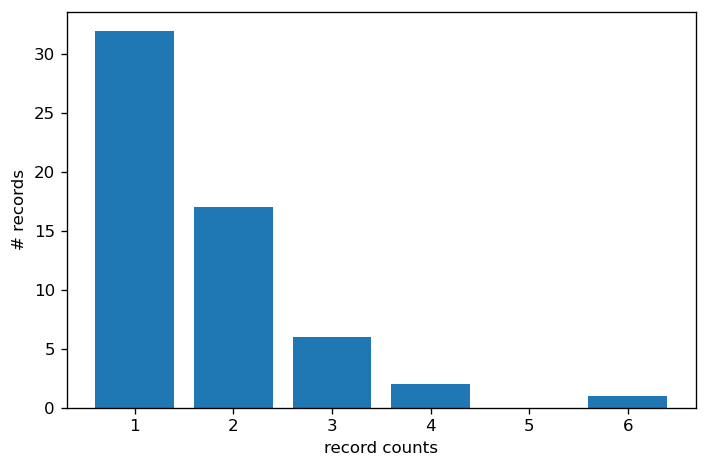

In [40]:
fig, ax = plt.subplots(**figargs)

data = synthdata.groupby('record_id').size().value_counts().sort_index()

ax.bar(data.index, data)
ax.set(xlabel='record counts', ylabel='# records')

fig.tight_layout()

### Genes

What genes do we have in the dataset?

In [41]:
genes = synthdata.loc[:, synthdata.columns.str.match(r'ln_47999_8_hgnc_\d')]\
  .melt(ignore_index=False)\
  .loc[lambda x: x['value'].str.contains('^HGNC:.*', na=False), 'value']
genes.unique()

array(['HGNC:6932'], dtype=object)

## Orchestrate the mapping 

Let's iterate over the dataset rows and map the data into phenopackets. We use the functions defined above.

In [42]:
def get_resource(id:str, name:str, namespace_prefix:str, url:str, version:str, iri_prefix:str) -> Resource:
    """A convenience method to create a Phenopacket Schema resource."""
    return Resource(id=id, name=name, namespace_prefix=namespace_prefix, url=url, version=version, iri_prefix=iri_prefix)

In [17]:
pps = []
# TODO: das hier ist am wichtigsten zu verstehen
# vorher quasi nur mapping, hier zusammensetzen
for i, (idx, row) in enumerate(synthdata.iterrows()):
    ## Subject
    # The elements we may consider adding:
    #  age at last encounter, vital status, karyotypic sex, gender
    
    subject = Individual(
        id=str(idx),
        date_of_birth=parse_erker_date_of_birth(row['sct_184099003_y']),
        sex=parse_erker_sex(row['sct_281053000']),
        taxonomy=OntologyClass(id='NCBITaxon:9606', label='Homo sapiens')
    )
    
    ## PhenotypicFeatures
    # Unsure if it is useful to add HPO terms in this dataset, 
    #  considering we have the weight measurements.
    phenotypicFeatures = PhenotypicFeature(
        type=OntologyClass(id='HP:0001513', label='Obesity')
        
    )
    ## Measurements
    # TODO - the weight course
    measurements=Measurement(

    )
    
    ## Interpretations
    interpretation=Interpretation(
        id=str(idx),
        progress_status='SOLVED',
       # diagnosis=Diagnosis(id='ORPHA:71529', label='Obesity due to melanocortin 4 receptor deficiency'),
    )
    
    # TODO - add variants
    variantInterpretation = VariantInterpretation(
        acmg_pathogenicity_classification='NOT_PROVIDED', #acmg will be added
        therapeutic_actionability='UNKNOWN_ACTIONABILITY',
      #  variant=parse_erker_hgvs()  
        
    )

    ## Disease
    disease = Disease(
        term=OntologyClass(id='ORPHA:71529',label='Obesity due to melanocortin 4 receptor deficiency'),
    #    onset=parse_erker_onset(row['sct_424850005']),
    )
   
    ## MetaData
    created = Timestamp()
    created.GetCurrentTime()
    
    resources = [
        get_resource('ncbitaxon', 'NCBI organismal classification', 'NCBITaxon', 
                     'http://purl.obolibrary.org/obo/ncbitaxon.owl', '2021-06-10', 'http://purl.obolibrary.org/obo/NCBITaxon_')
    ]
    
    
    meta_data = MetaData(
        created=created,
        created_by=created_by,
        submitted_by=created_by,  # The same for simplicity
        resources=resources,
        phenopacket_schema_version=phenopacket_schema_version
    )
    
    pp = Phenopacket(
        id=f'{i}-{idx}',  # TODO - can we come up with a better ID?
        subject=subject, 
        phenotypic_features=[phenotypicFeatures],
        interpretations=[interpretation],
        meta_data=meta_data,
        measurements=[],
        
        



        
        
    )
    pps.append(pp)
    
print(f'Mapped {len(pps)} phenopackets')

Mapped 98 phenopackets


## Store the phenopackets into JSON files

Let's store the phenopackets into JSON files, one file per phenopacket. We store the phenopackets in `phenopackets` folder by default.

In [18]:
from google.protobuf.json_format import MessageToJson

# Ensure the output directory exists
fpath_out = 'phenopackets'
os.makedirs(fpath_out, exist_ok=True)

# Write the phenopackets into JSON files
for pp in pps:
    json = MessageToJson(pp)
    fpath = os.path.join(fpath_out, pp.id)
    with open(fpath, 'w') as fh:
        fh.write(json)

**Done!**